In [61]:
# Code to connect Google colab to drive 
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [62]:
# Import OS to change directory
import os
os.chdir("/content/mydrive/MyDrive/")

In [63]:
# Importing the libraries
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Create a dataframe to load the data from json files
dataset = pd.DataFrame(columns = ['Rating', 'Score', 'Text'])

# To count the iterations 
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
import json

# Run multiple times for multiple files (Getting data in chunks)
# Opening JSON file
with open('Scrape_data_SD.json') as json_file:
    data = json.load(json_file)


In [66]:
# Importing the reviews data for chunk of data from the python dictionary into the dataframe
for hotel in data["hotel_list"]:
  if len(hotel["reviews_list"]) != 0:
    for review in hotel["reviews_list"]:
      for key, value in review.items():
        if float(review["Review_Rating"])>=5: # Load main reviews and assign neg or pos based on rating
          dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 1, 'Text' : review["Main_Review"] }, ignore_index = True)
        else:
          dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 0, 'Text' : review["Main_Review"] }, ignore_index = True)
        dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 0, 'Text' : review["Review_Dislikes"] }, ignore_index = True)
        dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 1, 'Text' : review["Review_Likes"] }, ignore_index = True)


Streaming output truncated to the last 5000 lines.
<ipython-input-66-8e8b5901077b>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 1, 'Text' : review["Review_Likes"] }, ignore_index = True)
<ipython-input-66-8e8b5901077b>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 1, 'Text' : review["Main_Review"] }, ignore_index = True)
<ipython-input-66-8e8b5901077b>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'Rating' : review["Review_Rating"], 'Score' : 0, 'Text' : review["Review_Dislikes"] }, ignore_index = True)
<ipython-input-66-8e8b5901077b>:11: Future

In [67]:
dataset # View the data imported

,Rating,Score,Text
0,9.0,1,None
1,9.0,0,None
2,9.0,1,Service de concierge excellent +++++
3,9.0,1,None
4,9.0,0,None
...,...,...,...
687517,7.0,0,None
687518,7.0,1,There are no comments available for this review
687519,7.0,1,Good
687520,7.0,0,None


In [68]:
# Dropping the duplicateds in the dataset
dataset = dataset.drop_duplicates(subset={"Rating","Score","Text"}, keep='first', inplace=False)

In [69]:
# Creating a backup table
dataset_backup = dataset.copy(deep=True)

In [ ]:
# Export the chunks of data to a CSV file
dataset_backup.to_csv('scrapping_data_SD.csv', index=False)

In [88]:
# Import data from CSV with full data
dataset_new = pd.read_csv('scrapping_data_final.csv')

In [89]:
# Dropping the duplicates in dataset (all cities combined)
dataset_new = dataset_new.drop_duplicates(subset={"Rating","Score","Text"}, keep='first', inplace=False)

In [90]:
len(dataset_new.index) # Finding the number of records

91155

In [91]:
dataset_new = dataset_new.dropna() # Droping rows with NaN
len(dataset_new.index) # Finding the number of records

89992

In [68]:
dataset_new.head() # Checking the head of table

,Rating,Score,Text
0,10,1.0,Exceptional
1,10,0.0,Price
2,10,1.0,Location was great. Very clean hotel
3,9,1.0,"Great hotel in a great location, good value"
5,9,1.0,"Great city view, the staff was very accommodat..."


In [94]:
import numpy as np
dataset = dataset_new[:].copy(deep=True) # Creating and copying into new table to use for classification model
dataset.head()

,Rating,Score,Text
0,10,1.0,Exceptional
1,10,0.0,Price
2,10,1.0,Location was great. Very clean hotel
3,9,1.0,"Great hotel in a great location, good value"
5,9,1.0,"Great city view, the staff was very accommodat..."


In [70]:
import nltk
nltk.download('wordnet') # Download wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [85]:
# Function to remove tags from the review texts
def removeHTMLTags(review):
    soup = BeautifulSoup(review, 'lxml')
    return soup.get_text()

# Function to remove apostrophes from the review texts
def removeApostrophe(review):
    phrase = re.sub(r"won't", "will not", review)
    phrase = re.sub(r"can\'t", "can not", review)
    phrase = re.sub(r"n\'t", " not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

# Function to remove alphanumeric words 
def removeAlphaNumericWords(review):
     return re.sub("\S*\d\S*", "", review).strip()

# Function to remove special characters and retain only alphabets  
def removeSpecialChars(review):
     return re.sub('[^a-zA-Z]', ' ', review)

# Generate scores
def scorePartition(x):
    if x == 0:
        return 0
    return 1

# Each review is cleaned by calling above helper functions
def doTextCleaning(review):
    review = removeHTMLTags(review)
    review = removeApostrophe(review)
    review = removeAlphaNumericWords(review)
    review = removeSpecialChars(review) 
    # Lower casing
    review = review.lower()  
    #Tokenization
    review = review.split()
    #Removing Stopwords and Lemmatization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word, 'v') for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

# Generalizing the score
actualScore = dataset['Score']
positiveNegative = actualScore.map(scorePartition) 
dataset['Score'] = positiveNegative


# creating the document corpus
corpus = []   
for index, row in tqdm(dataset.iterrows()):
    review = doTextCleaning(str(row['Text']))
    corpus.append(review)
    
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer

#Creating a tranform
cv = CountVectorizer(ngram_range=(1,3), max_features = 5000)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:,1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


1317it [00:02, 517.56it/s]<ipython-input-85-b2a4c1d24997>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(review, 'lxml')
100000it [03:17, 506.48it/s]


In [72]:
!pip install scikit-plot==0.3.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'Confusion matrix for Sentiment'}, xlabel='Predicted label', ylabel='True label'>

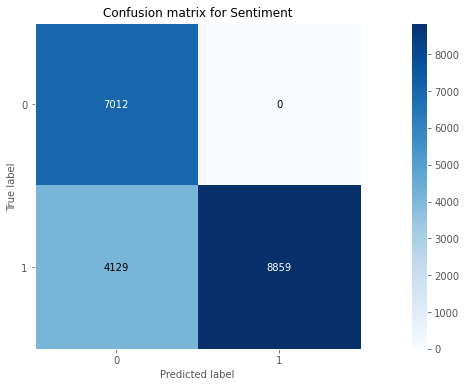

In [86]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train) # Fitting a classification model

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title = 'Confusion matrix for Sentiment')

In [87]:
count = 0
for i in range (0, len(y_test)):
  if(y_pred[i] == y_test[i]):
    count = count +1
# Calculating the accuracy
print('Accuracy = ',(count/len(y_test))*100, '%')

Accuracy =  79.355 %


In [92]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [95]:
num = len(dataset.index) # Get the number of records in the dataset

89992

In [96]:
dataset["row_id"] = [i for i in range (1,num+1)] # Add a row with row id
#print first 10 rows 
print (dataset.head(10))

   Rating  Score                                               Text  row_id
0      10    1.0                                        Exceptional       1
1      10    0.0                                              Price       2
2      10    1.0               Location was great. Very clean hotel       3
3       9    1.0        Great hotel in a great location, good value       4
5       9    1.0  Great city view, the staff was very accommodat...       5
6       9    1.0  Comfort, cleanliness, welcoming vibe, friendly...       6
7       9    1.0  Extremely pleasant experience from a late book...       7
8       8    1.0                                       It was great       8
10      8    1.0  I booked rooms with city view but did not get ...       9
11      8    1.0                              The beauty if the bed      10


In [97]:
#data clean-up
#remove all non-aphabet characters
dataset['Text'] = dataset['Text'].str.replace("[^a-zA-Z#]", " ")
#covert to lower-case
dataset['Text'] = dataset['Text'].str.casefold()
print (dataset.head(10))

<ipython-input-97-f51192aae0d2>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Text'] = dataset['Text'].str.replace("[^a-zA-Z#]", " ")


   Rating  Score                                               Text  row_id
0      10    1.0                                        exceptional       1
1      10    0.0                                              price       2
2      10    1.0               location was great  very clean hotel       3
3       9    1.0        great hotel in a great location  good value       4
5       9    1.0  great city view  the staff was very accommodat...       5
6       9    1.0  comfort  cleanliness  welcoming vibe  friendly...       6
7       9    1.0  extremely pleasant experience from a late book...       7
8       8    1.0                                       it was great       8
10      8    1.0  i booked rooms with city view but did not get ...       9
11      8    1.0                              the beauty if the bed      10


In [98]:
# set up empty dataframe for staging output
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [99]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer() # Load Sentiment analyzer to calculate polarity scores
t_df = df1
# Calculate polarity scores and insert into new table
for index, row in dataset.iterrows():
    scores = sid.polarity_scores(row[2])
    for key, value in scores.items():
        temp = [key,value,row[3]]
        df1['row_id']=row[3]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df.append(df1)
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
print(t_df_cleaned.head(10))

Processing sentiment analysis...


Streaming output truncated to the last 5000 lines.
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t

   row_id sentiment_type  sentiment_score
0       1            neg            0.000
0       1            neu            1.000
0       1            pos            0.000
0       1       compound            0.000
0       2            neg            0.000
0       2            neu            1.000
0       2            pos            0.000
0       2       compound            0.000
0       3            neg            0.000
0       3            neu            0.361


<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_df=t_df.append(df1)
<ipython-input-99-f1cc63ea73b4>:12:

In [100]:
# only keep rows where sentiment_type = compound
# Compound is the overall score that combines negative positive and neutral scores into a single score
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

   row_id sentiment_type  sentiment_score
0       1       compound           0.0000
0       2       compound           0.0000
0       3       compound           0.7960
0       4       compound           0.9260
0       5       compound           0.9231
0       6       compound           0.8776
0       7       compound           0.9448
0       8       compound           0.6249
0       9       compound           0.0000
0      10       compound           0.5859


In [101]:
t_df_cleaned

,row_id,sentiment_type,sentiment_score
0,1,compound,0.0000
0,2,compound,0.0000
0,3,compound,0.7960
0,4,compound,0.9260
0,5,compound,0.9231
...,...,...,...
0,89988,compound,0.9079
0,89989,compound,0.6249
0,89990,compound,0.4404
0,89991,compound,0.8689


In [102]:
#merge dataframes
df_output = pd.merge(dataset, t_df_cleaned, on='row_id', how='inner')
print(df_output.head(10))

  Rating  Score                                               Text  row_id  \
0     10    1.0                                        exceptional       1   
1     10    0.0                                              price       2   
2     10    1.0               location was great  very clean hotel       3   
3      9    1.0        great hotel in a great location  good value       4   
4      9    1.0  great city view  the staff was very accommodat...       5   
5      9    1.0  comfort  cleanliness  welcoming vibe  friendly...       6   
6      9    1.0  extremely pleasant experience from a late book...       7   
7      8    1.0                                       it was great       8   
8      8    1.0  i booked rooms with city view but did not get ...       9   
9      8    1.0                              the beauty if the bed      10   

  sentiment_type  sentiment_score  
0       compound           0.0000  
1       compound           0.0000  
2       compound           0.7960

In [103]:
df_output.to_csv('scrapping_data_scores.csv', index=False)

##Visualize the data

In [104]:
df_output[["sentiment_score"]].describe()

,sentiment_score
count,89992.000000
mean,0.292118
std,0.479544
min,-0.996000
25%,0.000000
50%,0.401900
75%,0.718400
max,0.998600


<Axes: title={'center': 'Sentiment Score'}, xlabel='Score', ylabel='Mean Sentiment Score'>

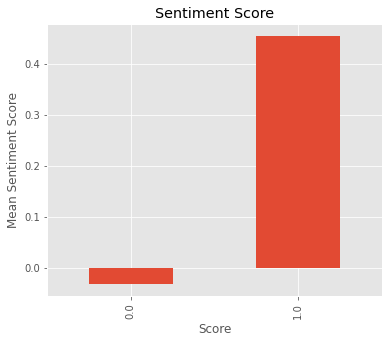

In [105]:
#generate mean of sentiment_score by period
dfg = df_output.groupby(['Score'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Score', figsize=(6, 5))

<Axes: title={'center': 'Sentiment Score'}, xlabel='Rating', ylabel='Mean Sentiment Score'>

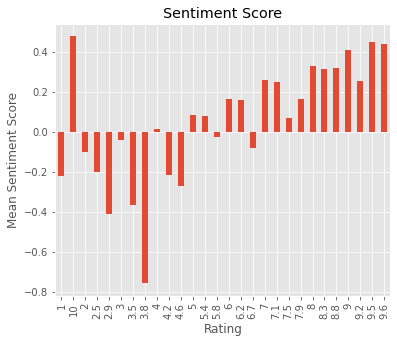

In [106]:
#generate mean of sentiment_score by period
dfg = df_output.groupby(['Rating'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Rating', figsize=(6, 5))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, '10'),
  Text(1, 0, '9'),
  Text(2, 0, '8'),
  Text(3, 0, '7'),
  Text(4, 0, '4'),
  Text(5, 0, '8.3'),
  Text(6, 0, '6'),
  Text(7, 0, '5'),
  Text(8, 0, '3'),
  Text(9, 0, '1'),
  Text(10, 0, '2'),
  Text(11, 0, '8.8'),
  Text(12, 0, '9.2'),
  Text(13, 0, '9.6'),
  Text(14, 0, '4.6'),
  Text(15, 0, '7.1'),
  Text(16, 0, '4.2'),
  Text(17, 0, '7.5'),
  Text(18, 0, '6.7'),
  Text(19, 0, '6.2'),
  Text(20, 0, '2.5'),
  Text(21, 0, '5.4'),
  Text(22, 0, '7.9'),
  Text(23, 0, '5.8'),
  Text(24, 0, '2.9'),
  Text(25, 0, '3.5'),
  Text(26, 0, '3.8'),
  Text(27, 0, '9.5')])

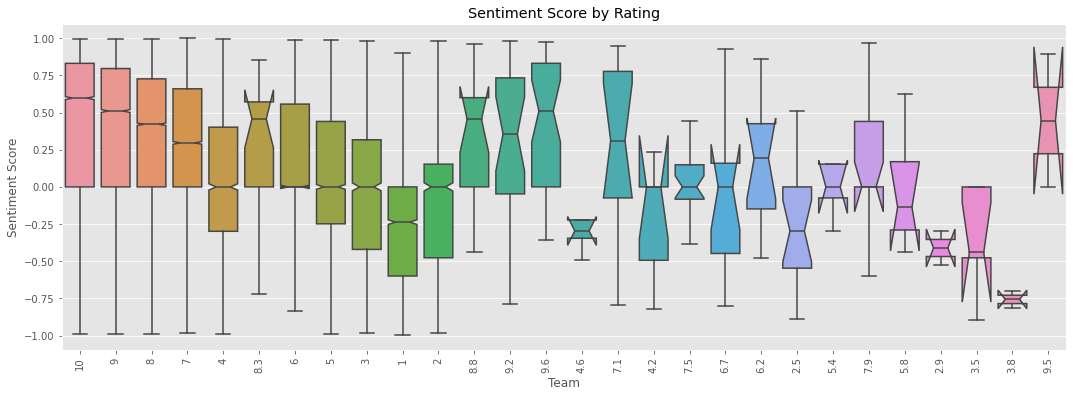

In [107]:
import seaborn as sns
#create seaborn boxplots by group
sns.boxplot(x='Rating', y='sentiment_score', notch = True,
            data=df_output, showfliers=False).set(title='Sentiment Score by Rating')
#modify axis labels
plt.xlabel('Team')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)

In [108]:
df_output.head()

,Rating,Score,Text,row_id,sentiment_type,sentiment_score
0,10,1.0,exceptional,1,compound,0.0000
1,10,0.0,price,2,compound,0.0000
2,10,1.0,location was great very clean hotel,3,compound,0.7960
3,9,1.0,great hotel in a great location good value,4,compound,0.9260
4,9,1.0,great city view the staff was very accommodat...,5,compound,0.9231


In [109]:
# VISUALIZATION
from wordcloud import WordCloud
from matplotlib import pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use("ggplot")

In [110]:
from statistics import mean
import math

# Create new table to visualize the average sentiment scores across ratings
df_display = pd.DataFrame(columns = ['Ratings','Score'])
df_display['labels_position'] = [1,2,3,4]*2 + [1,2]
lis_rating = {'1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], '8':[], '9':[], '10':[]}
lis_pos_neg = {'1':[],'2':[], '3':[], '4':[], '5':[], '6':[], '7':[], '8':[], '9':[], '10':[]}

# Get sentiment scores and pos/negative flag for all rows
for index, row in df_output.iterrows():
  try:
    lis_rating[str(row['Rating'])].append(row['sentiment_score'])
  except:
    continue
for index, row in df_output.iterrows():
  try:
    lis_pos_neg[str(row['Rating'])].append(row['Score'])
  except:
    continue
df_display['Ratings'] = lis_rating.keys()#[1,2,3,4,5,6,7,8,9,10]
df_display['Ratings'] = lis_rating.keys()

# Calculate mean sentiment scores for ratings
df_display['Score'] = [mean(value) for key, value in lis_rating.items()]
df_display = df_display.set_index(['Ratings'])
df_display

,Score,labels_position
Ratings,,
1,-0.220898,1
2,-0.103330,2
3,-0.042245,3
4,0.015997,4
5,0.085173,1
6,0.164928,2
7,0.257418,3
8,0.328694,4
9,0.409452,1


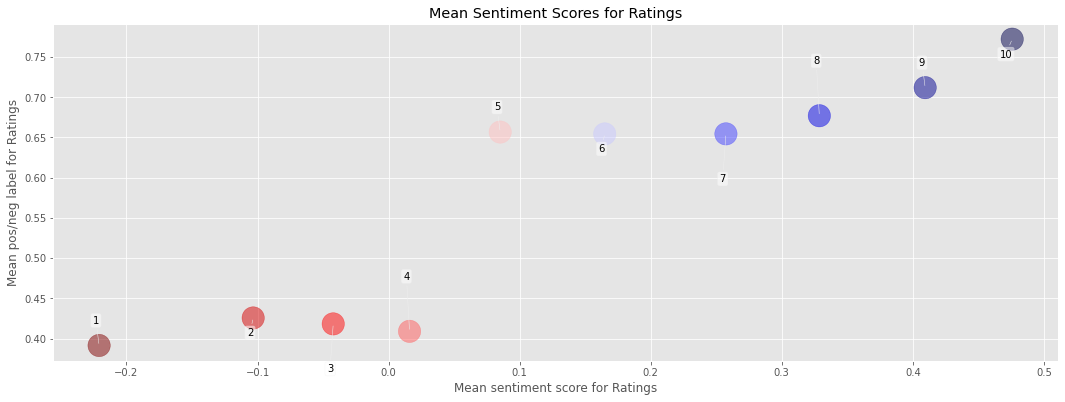

In [111]:
# USING MATPLOTLIB
plt.rcParams['figure.figsize'] = (18, 6)

x = df_display['Score']
#y = [0]*len(x)
y = [mean(value) for key, value in lis_pos_neg.items()] # Mean pos/neg falg for each ratings
colors = x

# Generate the plot to visualize Sentiment scores across Ratings
plt.subplots_adjust(bottom = 0.1)
plt.scatter(x, y, marker = "o", c=colors, cmap=plt.cm.seismic_r, s=500, alpha=0.5)

for pos, label, x, y in zip(df_display.get('labels_position'), df_display.index.values, x, y): 
    if pos==1:
        xytext = (0, 20)
    if pos==2:
        xytext = (0, -20)
    if pos==3:
        xytext = (0, -50)
    if pos==4:
        xytext = (0, 50)
    plt.annotate(
        label,
        xy=(x, y), xytext=xytext,
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round, pad=0.2', fc="white", alpha=0.5),
        arrowprops=dict(arrowstyle = '-', connectionstyle='arc3, rad=0'))

plt.xlabel("Mean sentiment score for Ratings")
plt.ylabel("Mean pos/neg label for Ratings")
plt.title("Mean Sentiment Scores for Ratings")
plt.show()